In [1]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset", 
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7553 files belonging to 2 classes.


In [7]:
class_name=dataset.class_names
class_name

['with_mask', 'without_mask']

In [10]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


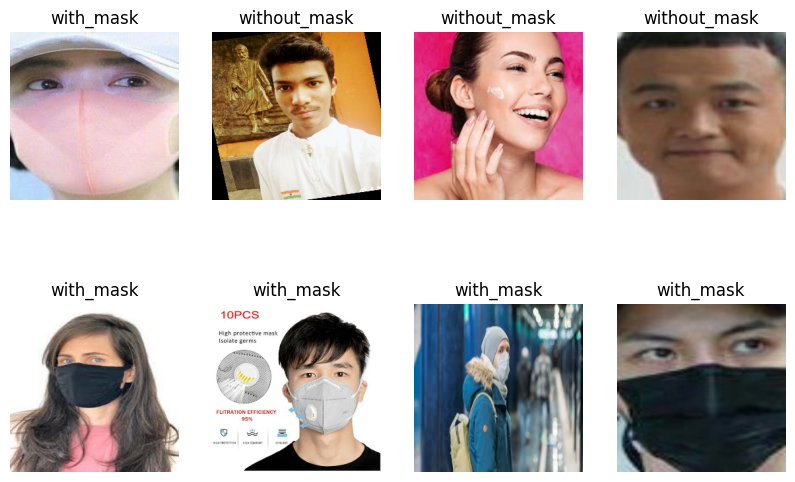

In [14]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range (8):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

code to divide the tarining validation and testing data 

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True , shuffle_size=10000):
    assert(train_split+test_split+val_split)==1

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

189

In [20]:
len(val_ds)

23

In [21]:
len(test_ds)

25

In [22]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

n_classes=2

model =models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
])


model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
189/189 [==============================] - 66s 278ms/step - loss: 0.4718 - accuracy: 0.7813 - val_loss: 0.4610 - val_accuracy: 0.8030
Epoch 2/50
189/189 [==============================] - 43s 225ms/step - loss: 0.3310 - accuracy: 0.8654 - val_loss: 0.5530 - val_accuracy: 0.7609
Epoch 3/50
189/189 [==============================] - 43s 226ms/step - loss: 0.3499 - accuracy: 0.8489 - val_loss: 0.4181 - val_accuracy: 0.8315
Epoch 4/50
189/189 [==============================] - 42s 222ms/step - loss: 0.2960 - accuracy: 0.8798 - val_loss: 0.4066 - val_accuracy: 0.8397
Epoch 5/50
189/189 [==============================] - 42s 222ms/step - loss: 0.2632 - accuracy: 0.8941 - val_loss: 0.3676 - val_accuracy: 0.8655
Epoch 6/50
189/189 [==============================] - 42s 222ms/step - loss: 0.2462 - accuracy: 0.9041 - val_loss: 0.3522 - val_accuracy: 0.8628
Epoch 7/50
189/189 [==============================] - 42s 222ms/step - loss: 0.2496 - accuracy: 0.9001 - val_loss: 0.3285 - val_ac

In [31]:

score=model.evaluate(test_ds)

25/25 [==============================] - 7s 39ms/step - loss: 0.2277 - accuracy: 0.9285


In [32]:
score

[0.22773221135139465, 0.9284785389900208]

In [33]:
history


In [34]:

history.params

{'verbose': 1, 'epochs': 50, 'steps': 189}

In [35]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

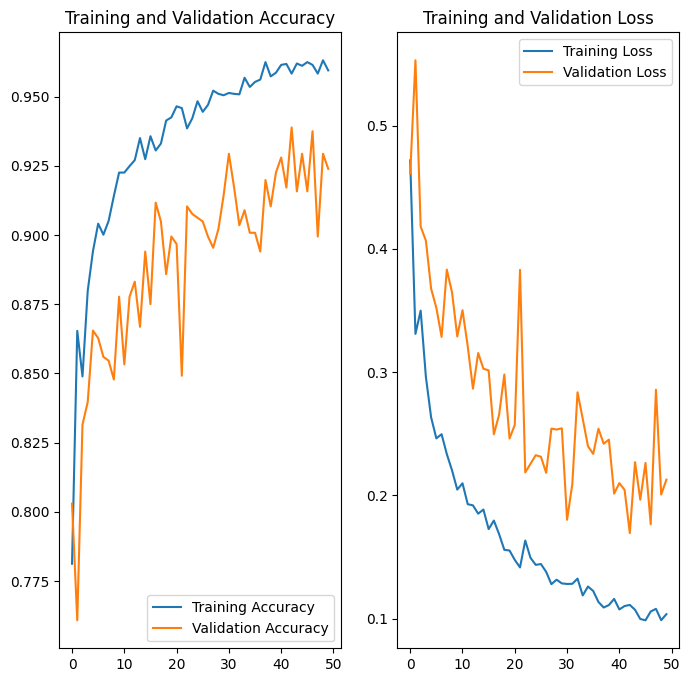

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()